In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [10]:
global_rng = np.random.default_rng(42)
true_params = { 
    'a':.75,
    'b': .85,
    'c': .5,
    'd': .65,
    'e':.9,
    'f':.8,
    'g':.2,
    'h':.15,
}
a = .75
b = .85
c = 0.5
d = .65
e = .9
f = .8
g = .2
h = .15

num_trails = 120 
true_probs = {
    'Other': 1-a,
    'Abstruse neologism': a * (1-b) * (1-f) * (1-h) + a * b * (1-c) * (1-f) * (1-h), 
    'Unrelated': a * (1-b) * (1-f) * h + a * (1-b) * f + a * b * (1-c) * (1-f) * h,
    'Semantic': a * b * (1-c) * f,
    'Neologism': a * b * c * (1-d) * (1-f) * (1-g) + a * b * c * d * (1-e) * (1-f) *(1-g) + a * b * c * d * e * (1-f) * (1-g),
    'Formal': a * b * c * (1-d) * (1-f) * g + a * b * c * (1-d) * f + a * b * c * d * (1-e) * (1-f) * g + a * b * c * d * e * (1-f) * g,
    'Mixed': a * b * c * d * (1-e) * f, 
    'Correct' : a * b * c * d * e * f 
}
data = global_rng.multinomial(n=num_trails,pvals=list(true_probs.values()))

In [11]:
data

array([34,  8, 15, 30,  3, 17,  2, 11])

In [12]:
mpt_model_code = """
data {
  int<lower=1> N;
  int<lower=1> K;
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> b;
  real<lower=0, upper=1> c;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> e;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> g;
  real<lower=0, upper=1> h;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = 1-a;
  theta[2] = a * (1-b) * (1-f) * (1-h) + a * b * (1-c) * (1-f) * (1-h);
  theta[3] = a * (1-b) * (1-f) * h + a * (1-b) * f + a * b * (1-c) * (1-f) * h;
  theta[4] = a * b * (1-c) * f;
  theta[5] = a * b * c * (1-d) * (1-f) * (1-g) + a * b * c * d * (1-e) * (1-f) *(1-g) + a * b * c * d * e * (1-f) * (1-g);
  theta[6] = a * b * c * (1-d) * (1-f) * g + a * b * c * (1-d) * f + a * b * c * d * (1-e) * (1-f) * g + a * b * c * d * e * (1-f) * g;
  theta[7] = a * b * c * d * (1-e) * f; 
  theta[8] = a * b * c * d * e * f;

}

model {
  target += beta_lpdf(a | 1, 1);
  target += beta_lpdf(b | 1, 1);
  target += beta_lpdf(c | 1, 1);
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(e | 1, 1);
  target += beta_lpdf(f | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += beta_lpdf(h | 1, 1);
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [13]:
stan_dict = {
    'freqs':data,
    'N' :num_trails,
    'K': data.shape[0]
}

posterior = stan.build(mpt_model_code, data=stan_dict,random_seed=42)

fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup =1000)



Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000131 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!


In [14]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.712,0.041,0.637,0.788,0.000,0.000,8926.0,6808.0,1.0
b,0.852,0.069,0.740,0.993,0.001,0.001,3968.0,3441.0,1.0
c,0.451,0.064,0.336,0.574,0.001,0.001,6215.0,6930.0,1.0
d,0.542,0.130,0.303,0.788,0.002,0.001,6001.0,4691.0,1.0
e,0.799,0.101,0.614,0.965,0.001,0.001,9340.0,5641.0,1.0
f,0.735,0.097,0.555,0.896,0.002,0.001,3682.0,6049.0,1.0
g,0.564,0.220,0.131,0.911,0.003,0.002,5376.0,4358.0,1.0
h,0.387,0.201,0.005,0.689,0.003,0.002,4016.0,4495.0,1.0
theta[0],0.288,0.041,0.212,0.363,0.000,0.000,8926.0,6808.0,1.0
theta[1],0.066,0.022,0.027,0.106,0.000,0.000,11846.0,8782.0,1.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='pred_freqs.8', ylabel='Count'>

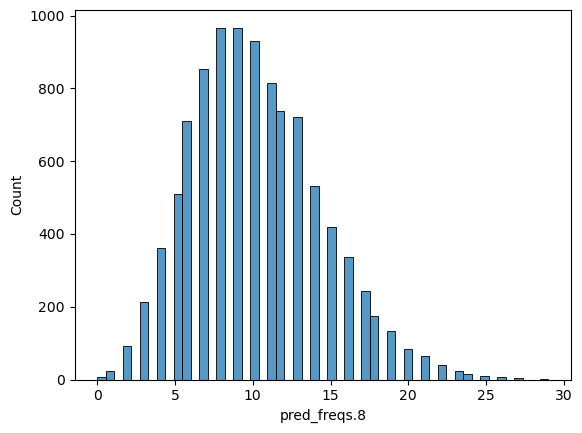

In [15]:
sns.histplot(fit.to_frame().iloc[:,-1])